In [252]:
import cv2
from skimage.io import imread
from skimage.filters import threshold_otsu,sobel_v,gaussian
from skimage.morphology import binary_closing,binary_opening
import matplotlib.pyplot as plt
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import numpy as np
from skimage.transform import resize
from skimage import feature 
import os
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

#import localization

In [224]:
car_image = imread('Images/car6.jpg', as_gray = True)
print(car_image.shape)

(1258, 1076)


In [225]:
gray_car_image = car_image * 255

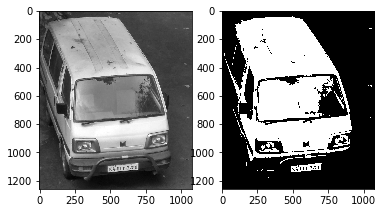

In [226]:
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.imshow(gray_car_image, cmap = 'gray')
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap='gray')
plt.show()

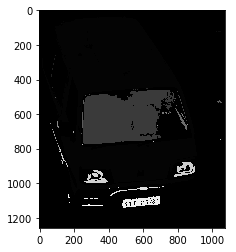

In [227]:
label_image = measure.label(binary_car_image)
fig, (ax1) = plt.subplots(1)
ax1.imshow(label_image, cmap="gray");


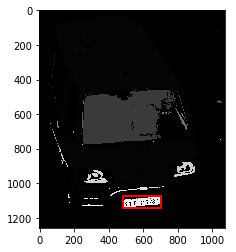

In [239]:
label_image = measure.label(binary_car_image)

# getting the maximum width, height and minimum width and height that a license plate can be(8-20% height and 15-40%width)
plate_dimensions = (0.05*label_image.shape[0], 0.3*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []
plate_like_objects_gray = []

fig, (ax1) = plt.subplots(1)
ax1.imshow(label_image, cmap="gray");
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    minRow, minCol, maxRow, maxCol = region.bbox
    
    #get the region height and width
    region_height = maxRow - minRow
    region_width = maxCol - minCol
    
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[minRow:maxRow,
                                  minCol:maxCol])
        plate_like_objects_gray.append(gray_car_image[minRow:maxRow,
                                  minCol:maxCol])
        plate_objects_cordinates.append((minRow, minCol,
                                              maxRow, maxCol))
        rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
   
   
    # let's draw a red rectangle over those regions
plt.show()


In [194]:
#sobelx= sobel_v(plate_like_objects[1])
#threshold_value = threshold_otsu(sobelx)
#binary_car_image = sobelx < threshold_value
#plt.imshow(binary_car_image,cmap="binary")


In [195]:
#"Return a list containing the sum of the pixels in each column"
#import numpy as np
#(h, w) = plate_like_objects[1].shape[:2]
#sumCols = []
#for j in range(h):
#    col = plate_like_objects[1][j:j+1, 0:w] # y1:y2, x1:x2
#    sumCols.append(np.sum(col))
#print(sumCols)

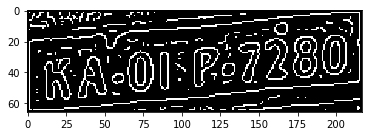

In [256]:
blur = gaussian(plate_like_objects_gray[0], sigma=1)
edges = np.invert(feature.canny(blur,sigma=1))

plt.imshow(edges,cmap="binary")

/home/nageen/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nageen/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


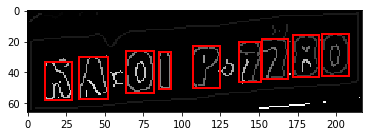

In [247]:
#license_plate = np.invert(plate_like_objects[1])
license_plate = np.invert(edges)

labelled_plate = measure.label(license_plate)

plate_like_objects_threhld = threshold_otsu(plate_like_objects_gray[0])
binary_plate_like_objects = plate_like_objects_gray[0] < plate_like_objects_threhld

fig, ax1 = plt.subplots(1)
ax1.imshow(labelled_plate, cmap="gray")

character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.03*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = binary_plate_like_objects[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()

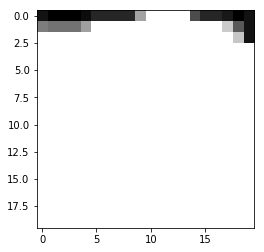

In [235]:
plt.imshow(characters[4],cmap="binary")


In [202]:
letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
]

In [147]:
def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            # read each image of each character
            img_details = imread(image_path, as_grey=True)
            # converts each character image to binary image
            binary_image = img_details < threshold_otsu(img_details)
            # the 2D array of each image is flattened because the machine learning
            # classifier requires that each sample is a 1D array
            # therefore the 20*20 image becomes 1*400
            # in machine learning terms that's 400 features with each pixel
            # representing a feature
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)

    return (np.array(image_data), np.array(target_data))

In [148]:

def cross_validation(model, num_of_fold, train_data, train_label):
    # this uses the concept of cross validation to measure the accuracy
    # of a model, the num_of_fold determines the type of validation
    # e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
    # it will divide the dataset into 4 and use 1/4 of it for testing
    # and the remaining 3/4 for the training
    accuracy_result = cross_val_score(model, train_data, train_label,
                                      cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)

In [149]:

#current_dir = os.path.dirname(os.path.realpath(__file__))
current_dir = os.getcwd()

training_dataset_dir = os.path.join(current_dir, 'train')

image_data, target_data = read_training_data(training_dataset_dir)

# the kernel can be 'linear', 'poly' or 'rbf'
# the probability was set to True so as to show
# how sure the model is of it's prediction
svc_model = SVC(kernel='linear', probability=True)

cross_validation(svc_model, 4, image_data, target_data)

# let's train the model with all the input data
svc_model.fit(image_data, target_data)

# we will use the joblib module to persist the model
# into files. This means that the next time we need to
# predict, we don't need to train the model again
save_directory = os.path.join(current_dir, 'models/svc/')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
joblib.dump(svc_model, save_directory+'/svc.pkl')

/home/nageen/.local/lib/python3.6/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Cross Validation Result for  4  -fold
[  96.07843137   99.01960784   95.58823529  100.        ]


['/home/nageen/PyImage/LicensePlaceDetector/models/svc//svc.pkl']

In [150]:
image_data.shape

(340, 400)

E


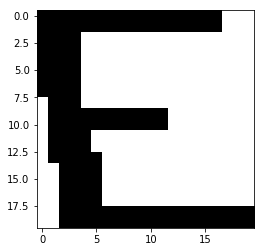

In [151]:
print(target_data[140])
plt.imshow(image_data[140].reshape(20,20),cmap="binary")

In [248]:

# load the model
current_dir = os.getcwd()
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

classification_result = []
for each_character in characters:
    # converts it to a 1D array
   
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

[array(['0'],
      dtype='<U1'), array(['6'],
      dtype='<U1'), array(['J'],
      dtype='<U1'), array(['7'],
      dtype='<U1'), array(['P'],
      dtype='<U1'), array(['0'],
      dtype='<U1'), array(['1'],
      dtype='<U1'), array(['A'],
      dtype='<U1'), array(['K'],
      dtype='<U1')]
06J7P01AK
KA01P7J60
